# Лабораторная работа 5: Прогнозирование временных рядов (LSTM)

 ## Импорт библиотек и константы

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Константы
SEED = 42
SEQ_LENGTH = 30     # Длина "окна" (смотрим на 30 дней назад)
HIDDEN_SIZE = 64    # Количество нейронов в LSTM слое
NUM_LAYERS = 2      # Количество слоев LSTM
EPOCHS = 100        # Эпохи обучения
LEARNING_RATE = 0.001

torch.manual_seed(SEED)
np.random.seed(SEED)

## 1. Загрузка Датасета

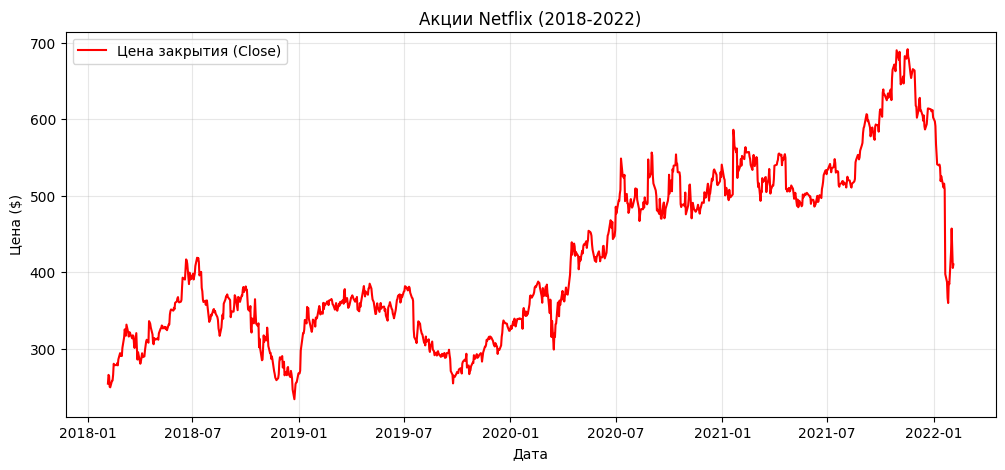

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [7]:
df = pd.read_csv('NFLX.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Визуализация исходных данных
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Цена закрытия (Close)', color='red')
plt.title("Акции Netflix (2018-2022)")
plt.xlabel("Дата")
plt.ylabel("Цена ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

df.head()

## 2. Предобработка данных

In [8]:
# Будем прогнозировать по колонке 'Close'
data = df['Close'].values.reshape(-1, 1).astype('float32')

# Разделение на train/test
# Отрезаем последние 20% данных для теста (имитация будущего)
train_size = int(len(data) * 0.80)
train_data_raw = data[:train_size]
test_data_raw = data[train_size:]

# Нормализация [0, 1]
scaler = MinMaxScaler()
# Обучаем скейлер ТОЛЬКО на тренировочной части!
train_data_scaled = scaler.fit_transform(train_data_raw)
test_data_scaled = scaler.transform(test_data_raw)

print(f"Обучающая выборка: {len(train_data_scaled)} дней")
print(f"Тестовая выборка: {len(test_data_scaled)} дней")

Обучающая выборка: 807 дней
Тестовая выборка: 202 дней


In [9]:
##  Подготовка последовательностей 
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(train_data_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data_scaled, SEQ_LENGTH)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Размерность X_train: {X_train_tensor.shape}") # [samples, 30, 1]
print(f"Размерность y_train: {y_train_tensor.shape}")


Размерность X_train: torch.Size([777, 30, 1])
Размерность y_train: torch.Size([777, 1])


## 3. Создание модели(LSTM)

In [10]:
# Архитектура:
# `Input (30 дней)` -> `LSTM` -> `Linear` -> `Output (Цена завтра)`

class StockPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM слой
        # dropout добавляет регуляризацию между слоями LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Инициализация скрытых состояний
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Проход через LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Берем выход последнего временного шага (прогноз после просмотра всех 30 дней)
        out = self.fc(out[:, -1, :])
        return out

model = StockPredictor(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
print(model)

StockPredictor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 4. Обучение модели

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_hist = []
test_hist = []

for epoch in range(EPOCHS):
    model.train()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_hist.append(loss.item())
    
    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        test_hist.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {loss.item():.5f} | Test Loss: {test_loss.item():.5f}")

Epoch 10/100 | Train Loss: 0.11402 | Test Loss: 0.50349
Epoch 20/100 | Train Loss: 0.05566 | Test Loss: 0.18012
Epoch 30/100 | Train Loss: 0.04710 | Test Loss: 0.25715
Epoch 40/100 | Train Loss: 0.03049 | Test Loss: 0.04370
Epoch 50/100 | Train Loss: 0.00727 | Test Loss: 0.05677
Epoch 60/100 | Train Loss: 0.00713 | Test Loss: 0.02810
Epoch 70/100 | Train Loss: 0.00531 | Test Loss: 0.01265
Epoch 80/100 | Train Loss: 0.00475 | Test Loss: 0.01211
Epoch 90/100 | Train Loss: 0.00432 | Test Loss: 0.01290
Epoch 100/100 | Train Loss: 0.00407 | Test Loss: 0.01184


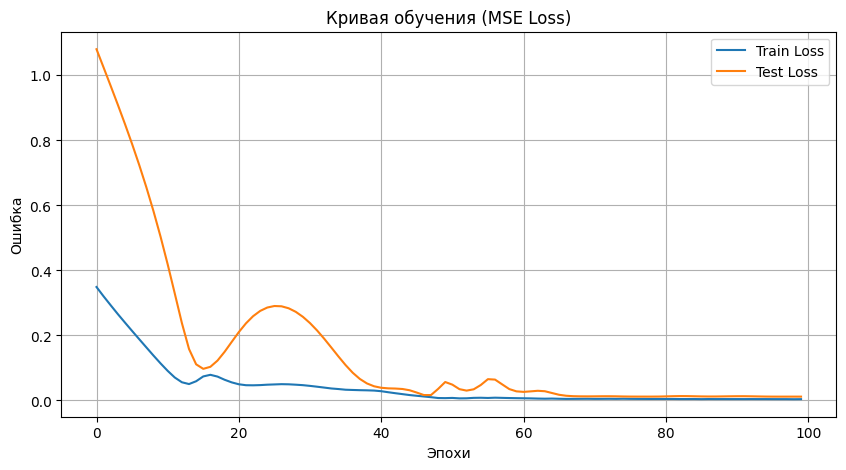

In [12]:
# График обучения
plt.figure(figsize=(10, 5))
plt.plot(train_hist, label="Train Loss")
plt.plot(test_hist, label="Test Loss")
plt.title("Кривая обучения (MSE Loss)")
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.legend()
plt.grid(True)
plt.show()

## 5. Визуализация прогноза

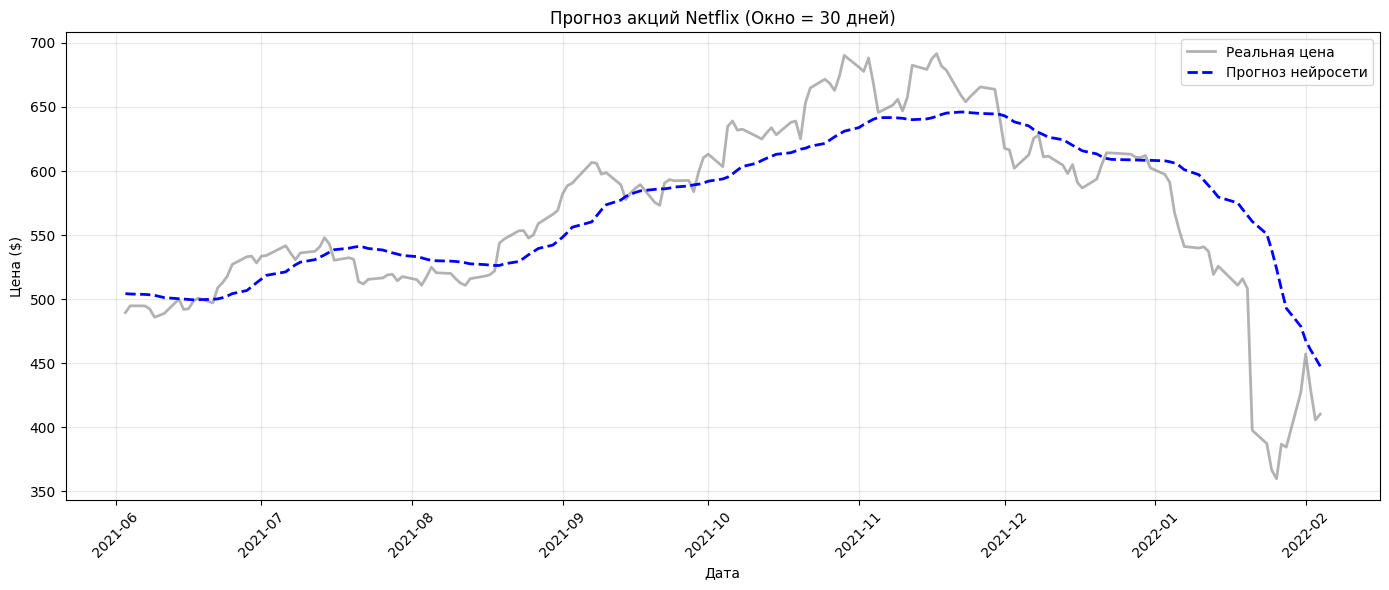

In [15]:
model.eval()
with torch.no_grad():
    predicted_scaled = model(X_test_tensor).numpy()

# Возвращаем к оригинальному масштабу ($)
predicted_prices = scaler.inverse_transform(predicted_scaled)
real_prices = scaler.inverse_transform(y_test_tensor.numpy())

# Получаем соответствующие даты для оси X
test_dates = df['Date'].iloc[train_size + SEQ_LENGTH:].values

# Строим график
plt.figure(figsize=(14, 6))

plt.plot(test_dates, real_prices, label='Реальная цена', color='gray', alpha=0.6, linewidth=2)
plt.plot(test_dates, predicted_prices, label='Прогноз нейросети', color='blue', linestyle='--', linewidth=2)

plt.title(f"Прогноз акций Netflix (Окно = {SEQ_LENGTH} дней)")
plt.xlabel("Дата")
plt.ylabel("Цена ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Оценка в цифрах
last_real = real_prices[-1][0]
last_pred = predicted_prices[-1][0]
error_abs = abs(last_real - last_pred)
error_pct = (error_abs / last_real) * 100

print(f"\n--- Результат на последнюю дату ---")
print(f"Реальная цена: ${last_real:.2f}")
print(f"Прогноз LSTM:  ${last_pred:.2f}")
print(f"Ошибка:        ${error_abs:.2f} ({error_pct:.2f}%)")


--- Результат на последнюю дату ---
Реальная цена: $410.17
Прогноз LSTM:  $447.50
Ошибка:        $37.33 (9.10%)
